# Part 1. Protein-Protein Interactions in Phentypic Description Data
The purpose of this notebook is to answer the question of how networks genereated using phenotypic-text similarity based approaches through either embedding, vocabulary presence, or ontology annotation compare to or relate to networks that specify known protein-protein interactions. The hypothesis that these networks are potentially related is based on the idea that if two proteins interact, they are likely to be acting in a common pathway with a common biological function. If the phenotypic outcome of this pathway is observable and documented, then similarites between text describing the mutant phenotype for these genes may coincide with direct protein-protein interactions. The different sections in this notebook correspond to different ways of determining if the graphs based on similarity between text descriptions, encodings of text descriptions, or annotations derived from text descriptions at all correspond to known protein-protein interactions in this dataset. The knowledge source about the protein-protein interactions for genes in this dataset is the STRING database. The available entries in the whole dataset are subset to include only the genes that correspond to proteins that are atleast mentioned in the STRING database. This ways if a protein-protein interaction is not specified between two of the remaining genes, it is not because no interactions at all are documented either of those genes. The following cells focus on setting up a dataframe which specifies edge lists specific to each similarity method, and also a protein-protein interaction score for the genes which correspond to those two given nodes in the graphs.

In [13]:
import datetime
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter, defaultdict
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split, KFold
from scipy import spatial

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import String
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_doc2vec_onegroup, pairwise_counting_onegroup, pairwise_annotations_onegroup
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids, pairwise_word2vec_onegroup
from oats.graphs.pairwise import remove_self_loops
from oats.graphs.models import train_logistic_regression_model, apply_logistic_regression_model
from oats.graphs.models import train_random_forest_model, apply_random_forest_model

nltk.download('punkt')
mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package punkt to /Users/irbraun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Nested dictionary to summarize output with shape dict[method][(tag,metric)] --> value
# The dictionary is organized this way for printing within this notebook and saving as a csv file.
TAG = "protein-protein"
TABLE = defaultdict(dict)
OUTPUT_DIR = os.path.join("../outputs",datetime.datetime.now().strftime('%m_%d_%Y_h%Hm%Ms%S'))
os.mkdir(OUTPUT_DIR)

### 1.1 Reading in the dataset and subsetting based on mentions in the protein-protein interaction data
The dataset can be loaded from an existing dataset object that was saved as a pickle, or csv files can be loaded directly into a new dataset object. Subsetting here is done so that only genes that are mentioned atleast once in the STRING data files are retained. Note that this included genes that are mentioned but only in the context of interactions with other genes that are not in this dataset. This means that not every gene retained will have a positive edge in the network once the pairwise similarity graph is generated. This is done so that the remaining data is not overly biased towards including more interactions than would be expected. 

In [3]:
# Reading in the entire dataset, subsetting for Arabidopsis and all annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotations()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [4]:
# Reduce size of the dataset by removing genes not mentioned in the STRING.
naming_file = "../data/group_related_files/string/all_organisms.name_2_string.tsv"
interactions_file_1 = "../data/group_related_files/string/3702.protein.links.detailed.v11.0.txt"
interactions_file_2 = "../data/group_related_files/string/4577.protein.links.detailed.v11.0.txt"
genes = dataset.get_gene_dictionary()
string_data = String(genes, naming_file, interactions_file_1, interactions_file_2)
dataset.filter_with_ids(string_data.ids)
dataset.filter_random_k(100)
dataset.describe()



# TODO add section for making tables of how many inputs were successfully mapped to the STRING db.

Number of rows in the dataframe: 100
Number of unique IDs:            100
Number of unique descriptions:   95
Number of unique gene name sets: 100
Number of species represented:   1


### 1.2 Preprocessing of text descriptions, generating vocabularies, and other optional steps

In [5]:
# Make a dictionary of descriptions with same quantity of words but randomly selected from the vocabulary.
from nltk.tokenize import word_tokenize
#descriptions = dataset.get_description_dictionary()
#annotations = dataset.get_annotations_dictionary()
#go_annotations = {k:[term for term in v if term[0:2]=="GO"] for k,v in annotations.items()}
#po_annotations = {k:[term for term in v if term[0:2]=="PO"] for k,v in annotations.items()}
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

### 1.3 Generating vector representations, pairwise similarity matrices, and edgelists

In [6]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
word2vec_model_filename = "../gensim/wiki_sg/word2vec.bin"
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
vocabulary = ontology.get_vocabulary()


# Generating the pairwise edgelist for some vanilla methods.
graphs = {} # A mapping between method names and graph objects containing edgelists and vector mappings.
graphs["doc2vec"] = pairwise_doc2vec_onegroup(doc2vec_model, descriptions, metric="cosine")
graphs["bagofwords"] = pairwise_counting_onegroup(descriptions, binary=False, metric="cosine") 
graphs["setofwords"] = pairwise_counting_onegroup(descriptions, binary=True, metric="cosine")
graphs["ontology"] = pairwise_annotations_onegroup(annotations, ontology, binary=True, metric="cosine")

# Generating the pairwise edgelists for some additional methods.
graphs["bag_w12gram"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="word", ngram_range=(1,2), max_features=1000)
graphs["bag_c36gram"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="char", ngram_range=(4,6), max_features=1000)
graphs["bag_reduced"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, vocabulary=vocabulary)
graphs["set_reduced"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=True, vocabulary=vocabulary)

# Generating the pairwise edgelists for some additional methods.
graphs["w2v_mean"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="mean")
graphs["w2v_max"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="max")
print("{} methods completed".format(len(graphs)))

10 methods completed


In [22]:
# Merging all of the edgelist dataframes together.
methods = list(graphs.keys())
edgelists = {k:v.edgelist for k,v in graphs.items()}
df = merge_edgelists(edgelists, default_value=0.000)
df = remove_self_loops(df)
df.tail(12)

,from,to,doc2vec,bagofwords,setofwords,ontology,bag_w12gram,bag_c36gram,bag_reduced,set_reduced,w2v_mean,w2v_max
5033,7590,2258,0.428072,0.940424,0.945847,0.459926,0.948144,0.760985,0.894591,0.900985,0.409454,0.226161
5034,7590,4525,0.394521,0.942169,0.912879,0.061748,0.930993,0.889762,0.948969,0.900985,0.249732,0.133882
5036,689,2576,0.463954,0.983751,0.951493,0.604495,0.986852,0.982438,0.980426,0.925464,0.475017,0.134781
5037,689,144,0.376546,0.977247,0.914251,0.551735,0.987001,0.952434,0.965665,0.841886,0.414555,0.223951
5038,689,2258,0.461968,0.994197,0.926873,0.585130,0.996580,0.998349,0.990773,0.870901,0.536987,0.253897
5039,689,4525,0.315548,0.977467,0.941176,0.593942,0.981797,0.979397,0.964263,0.870901,0.356291,0.127632
5041,2576,144,0.471567,0.915983,0.858579,0.096922,0.935523,0.951079,0.868441,0.764298,0.429261,0.237685
5042,2576,2258,0.489375,0.971429,0.939698,0.442117,0.977383,0.990425,0.952860,0.903775,0.309966,0.194674
5043,2576,4525,0.488831,0.694915,0.854479,0.086831,0.608746,0.743954,0.497921,0.711325,0.220680,0.134516
5045,144,2258,0.419389,1.000000,1.000000,0.406052,1.000000,1.000000,1.000000,1.000000,0.482124,0.299767


### 1.4 Merging the dataset with information about protein-protein interactions

In [23]:
# Merging information from the protein-protein interaction database with this dataset.
df = df.merge(right=string_data.df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
df["interaction"] = (df["combined_score"] != 0.00)*1
df.tail(12)

,from,to,doc2vec,bagofwords,setofwords,ontology,bag_w12gram,bag_c36gram,bag_reduced,set_reduced,w2v_mean,w2v_max,combined_score,interaction
4957,7590,2258,0.428072,0.940424,0.945847,0.459926,0.948144,0.760985,0.894591,0.900985,0.409454,0.226161,0.0,0
4958,7590,4525,0.394521,0.942169,0.912879,0.061748,0.930993,0.889762,0.948969,0.900985,0.249732,0.133882,0.0,0
4959,689,2576,0.463954,0.983751,0.951493,0.604495,0.986852,0.982438,0.980426,0.925464,0.475017,0.134781,0.0,0
4960,689,144,0.376546,0.977247,0.914251,0.551735,0.987001,0.952434,0.965665,0.841886,0.414555,0.223951,0.0,0
4961,689,2258,0.461968,0.994197,0.926873,0.585130,0.996580,0.998349,0.990773,0.870901,0.536987,0.253897,0.0,0
4962,689,4525,0.315548,0.977467,0.941176,0.593942,0.981797,0.979397,0.964263,0.870901,0.356291,0.127632,0.0,0
4963,2576,144,0.471567,0.915983,0.858579,0.096922,0.935523,0.951079,0.868441,0.764298,0.429261,0.237685,0.0,0
4964,2576,2258,0.489375,0.971429,0.939698,0.442117,0.977383,0.990425,0.952860,0.903775,0.309966,0.194674,0.0,0
4965,2576,4525,0.488831,0.694915,0.854479,0.086831,0.608746,0.743954,0.497921,0.711325,0.220680,0.134516,0.0,0
4966,144,2258,0.419389,1.000000,1.000000,0.406052,1.000000,1.000000,1.000000,1.000000,0.482124,0.299767,0.0,0


### 1.5 Training logistic regression or random forest models to combine multiple methods
The purpose of this section is to iteratively train models on subsections of the dataset using simple regression or machine learning approaches to predict a value from zero to one indicating indicating how likely is it that two genes code for proteins that share an interaction. The information input to these models is the distance scores provided by each method in some set of all the methods used in this notebook. The purpose is to see whether or not a function of these similarity scores specifically trained to the task of predicting protein interactions is better able to used the distance metric information to report a score for this task.

In [24]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "logistic_regression"
splits = 12
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    lr_model = train_logistic_regression_model(df=df.iloc[train], predictor_columns=methods, target_column="interaction")
    df[method].iloc[test] = apply_logistic_regression_model(df=df.iloc[test], predictor_columns=methods, model=lr_model)
df[method] = 1-df[method]
methods.append(method)

In [25]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
method = "random_forest"
splits = 2
kf = KFold(n_splits=splits, random_state=14271, shuffle=True)
df[method] = pd.Series()
for train,test in kf.split(df):
    rf_model = train_random_forest_model(df=df.iloc[train], predictor_columns=methods, target_column="interaction")
    df[method].iloc[test] = apply_random_forest_model(df=df.iloc[test],predictor_columns=methods, model=rf_model)
df[method] = 1-df[method]
methods.append(method)

### 1.6 Do the edges joining interacting proteins come from a different distribution?
This section uses a statistical test (Kolmogorov-Smirnov) to see if the distributions of edge weights which correspond to edges representing a known protein interaction come from a different distribution than the edge weights for edges that do not. This test was chosen because the sizes of the two samples can be different and there is no assumption of normality for the underlying distributions. Visualization of the densities of the distributions that are tested in the previous cell. This is a check to see if the differences between the distribution of weights based on text-similarity corresponding to known protein-protein interactions are distinct enough those that do not to be practically useful in predicting interactions based on text-similarity.

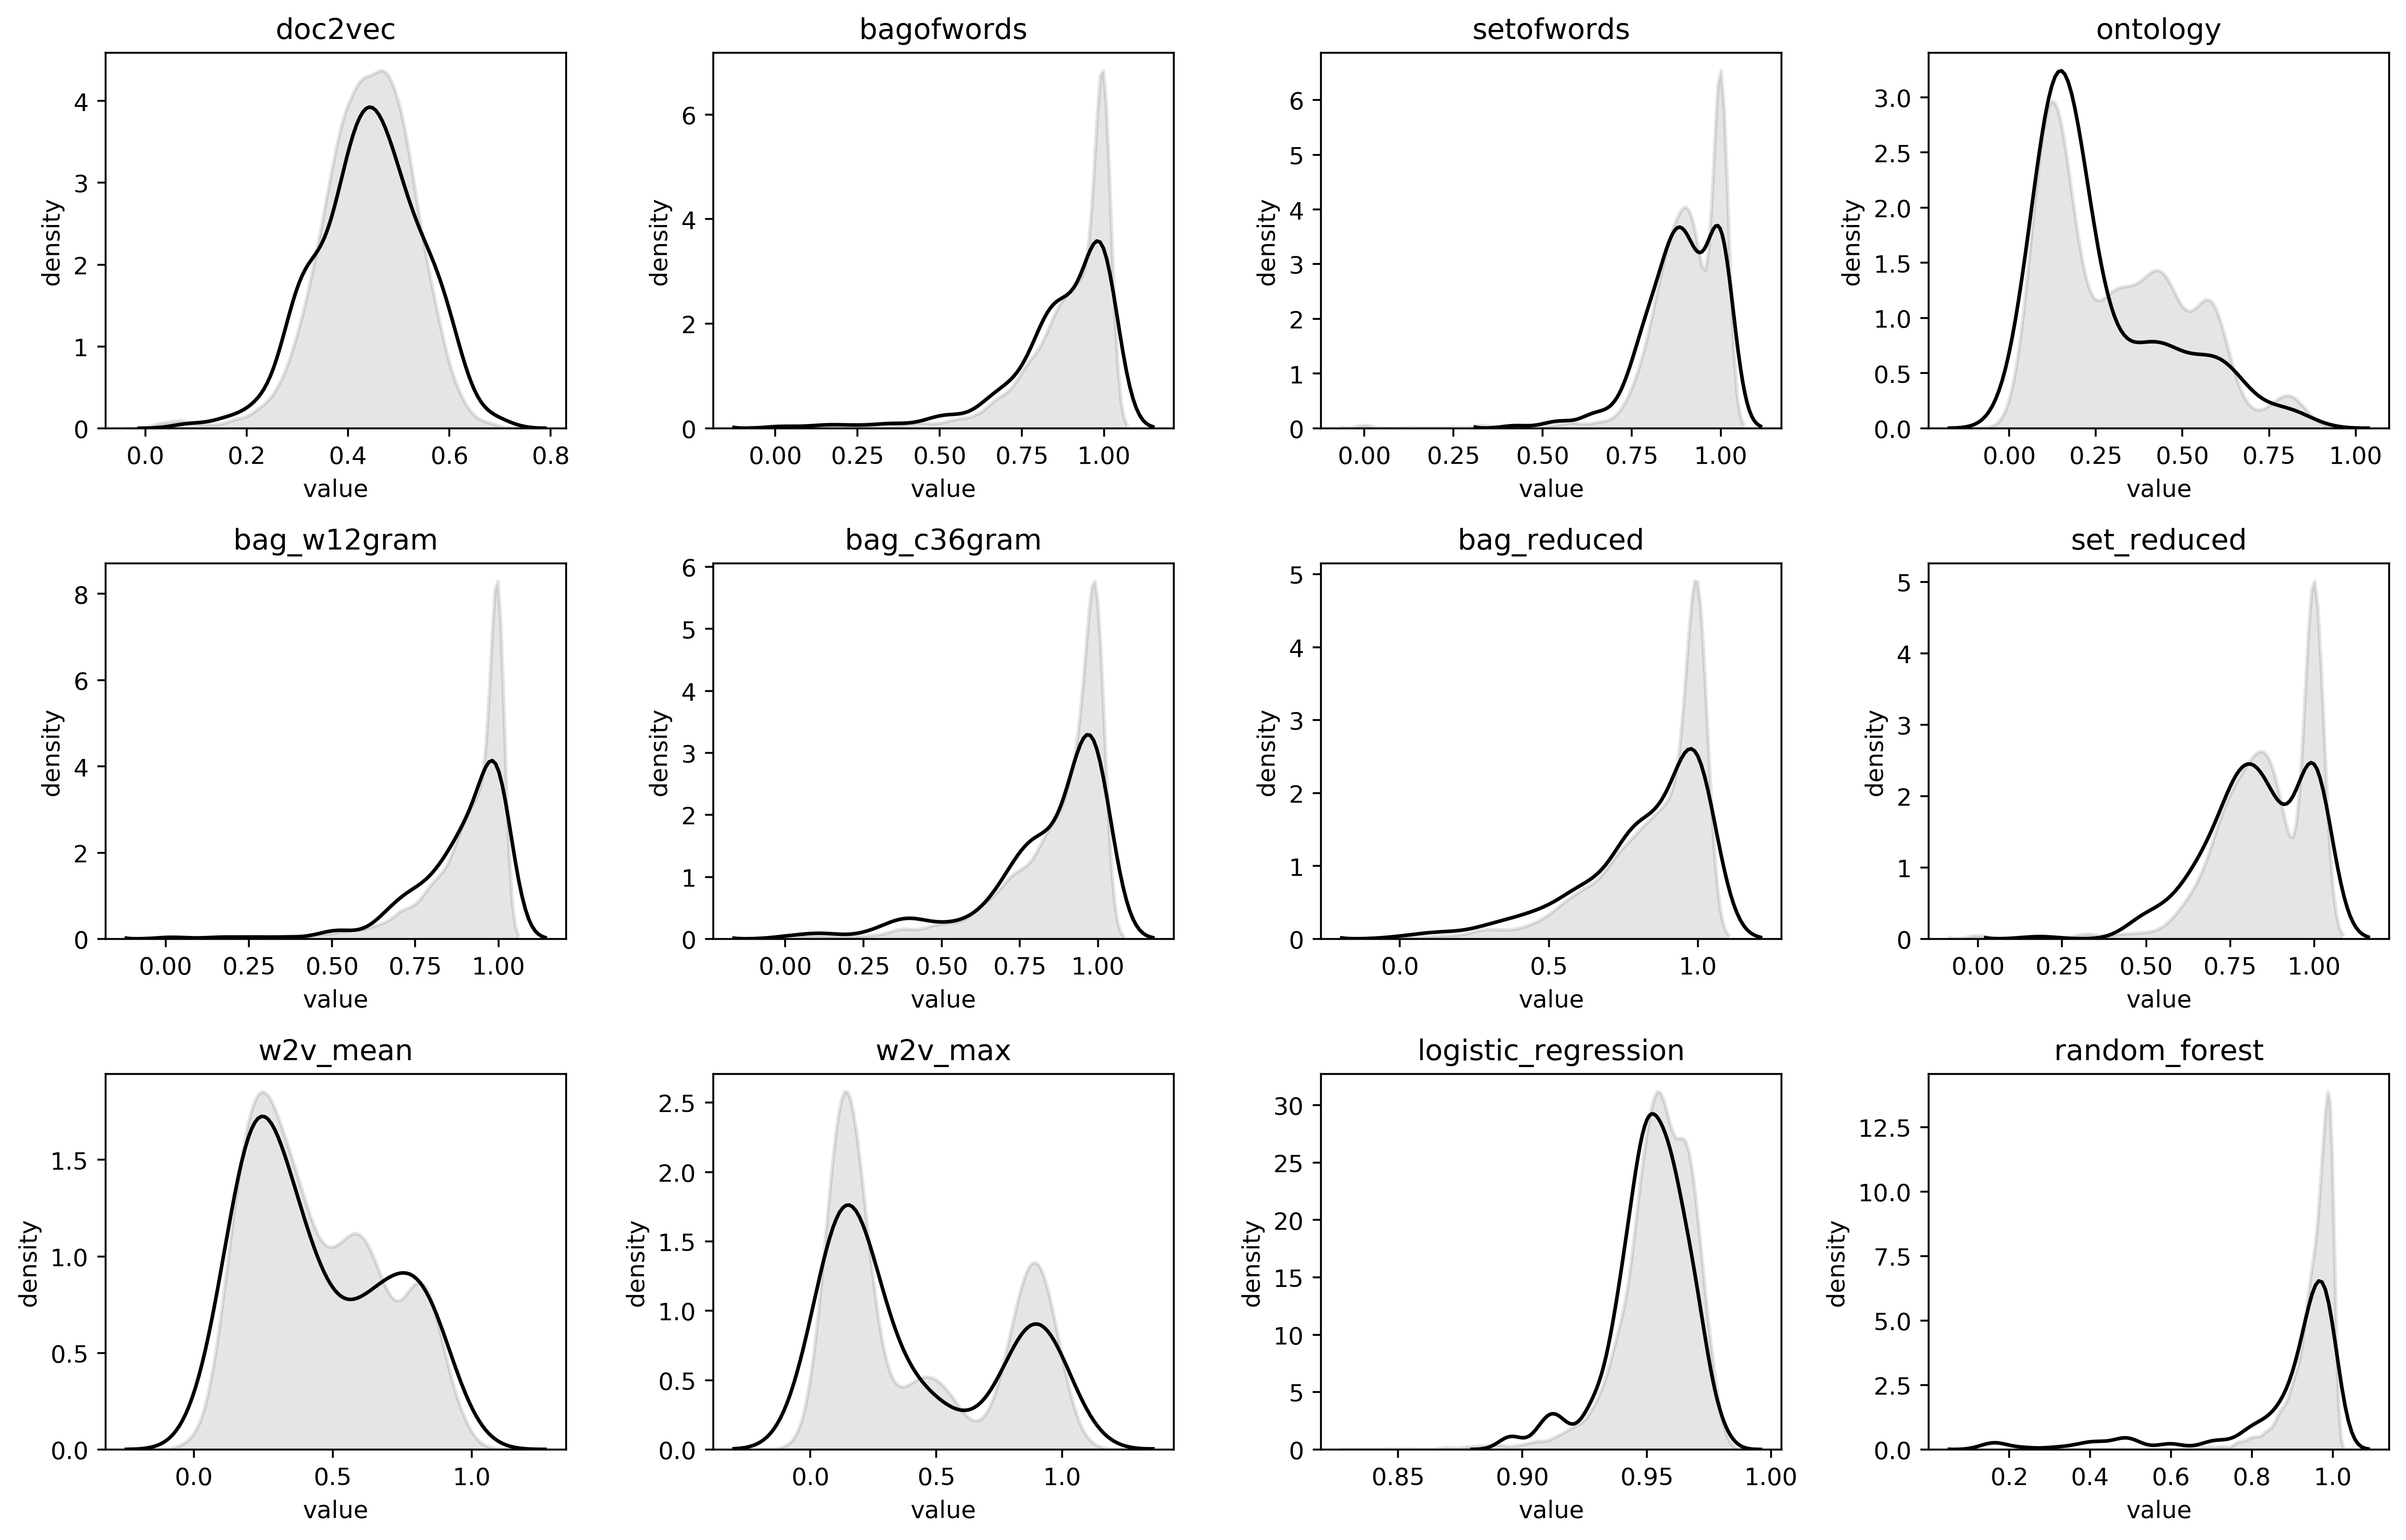

In [26]:
# Use Kolmogorov-Smirnov test to see if protein-protein interaction edges come from a distinct distribution.
ppi_pos_dict = {name:(df[df["combined_score"] > 0.00][name].values) for name in methods}
ppi_neg_dict = {name:(df[df["combined_score"] == 0.00][name].values) for name in methods}
for name in methods:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    TABLE[name].update({(TAG,"mean_1"):pos_mean, (TAG,"mean_0"):neg_mean, (TAG,"n_1"):pos_n, (TAG,"n_0"):neg_n})
    TABLE[name].update({(TAG,"ks"):stat, (TAG,"ks_pval"):p})

# Show the kernel estimates for each distribution and distribution of interaction weights for each method.
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods,axs.flatten()):
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[name], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[name], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"kernel_density.png"))

### 1.7 Are the edge weights in each network generally predictive of known protein-protein interactions?
This is a different question than above, because the false positive rate is a limiting factor in how practically useful it would be to generate predictions about real protein interactions. In the case of the statistical test above, the sample distribution could be significantly different than the whole distribution of edge values even if there are many high valued edges which look like they could come from the sample distribution. In other words, the sample distribution could be distinct because of a lack of low edge weight values, not there could still be many high edge weight values that are not positive edges in this case, which represent false positives).

In [ ]:
# Generate the targe class values, 1 indicating interaction and 0 indicating no interaction.
y_true_dict = {name:(np.where(df["combined_score"] > 0.000, 1, 0)) for name in methods}
y_prob_dict = {name:(1 - df[name].values) for name in methods}
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[name], y_prob_dict[name]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    TABLE[name].update({(TAG,"auc"):area, (TAG,"baseline"):baseline, (TAG,"ratio"):auc_to_baseline_auc_ratio})
    
    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(name, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(OUTPUT_DIR,"prcurve_interaction.png"))

### 1.8 Are interacting partners ranked higher with respect to individual nodes?
This is a way of statistically seeing if for some value k, the graph ranks more edges from some particular gene to any other gene that it has a true protein-protein interaction with higher or equal to rank k, than we would expect due to random chance. This way of looking at the problem helps to be less ambiguous than the previous methods, because it gets at the core of how this would actually be used. In other words, we don't really care how much true information we're missing as long as we're still able to pick up some new useful information by building these networks, so even though we could be missing a lot, what's going on at the very top of the results? These results should be comparable to very strictly thresholding the network and saying that the remaining edges are our guesses at interactions. This is comparable to just looking at the far left-hand side of the precision recall curves, but just quantifies it slightly differently.

In [ ]:
# Convert the undirected edgelist where an edge (j,i) is always implied by an edge (i,j) to a directed edgelist where
# both the (i,j) and (j,i) edges are explicity present in the dataframe. This is done so that we can make us of the
# groupby function to obtain all groups that contain all edges between some given node and everything its mapped to 
# by just grouping base on one of the columns specifying a node. This is easier than using a multi-indexed dataframe.
other_columns = df.columns[2:]
flipped_edges = df[flatten(["to","from",other_columns])]      # Create the flipped duplicate dataframe.
flipped_edges.columns = flatten(["from","to",other_columns])  # Rename the columns so it will stack correctly
df = pd.concat([df, flipped_edges])
df.drop_duplicates(keep="first", inplace=True)
print(df.shape)

In [ ]:
k = 10 # The threshold of interest for gene ranks.
n = 1000 # Number of Monte Carlo simulation iterations to do.

# What's the number of functional partners ranked k or higher in terms of phenotypic description similarity for 
# each gene? Also figure out the maximum possible number of functional partners that could be theoretically
# recovered in this dataset if recovered means being ranked as k or higher here.
df[list(methods)] = df.groupby("from")[list(methods)].rank()
ys = df[df["combined_score"]>0.0][list(methods)].apply(lambda s: len([x for x in s if x<=k]))
ymax = sum(df.groupby("from")["combined_score"].apply(lambda s: min(len([x for x in s if x>0.00]),k)))

# Monte Carlo simulation to see what the probability is of achieving each y-value by just randomly pulling k 
# edges for each gene rather than taking the top k ones that the similarity methods specifies when ranking.
ysims = [sum(df.groupby("from")["combined_score"].apply(lambda s: len([x for x in s.sample(k) if x>0.00]))) for i in range(n)]
for method in methods:
    pvalue = len([ysim for ysim in ysims if ysim>=ys[method]])/float(n)
    TABLE[method][(TAG,"y")] = ys[method]
    TABLE[method][(TAG,"y_max")] = ymax
    TABLE[method][(TAG,"y_pval")] = pvalue

### 1.9 Summarizing the results for this notebook

In [ ]:
results = pd.DataFrame(TABLE).transpose()
results.to_csv(os.path.join(OUTPUT_DIR,"table.csv"))
results